## Configuration

In [13]:
import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torchvision.models as models
import matplotlib.pyplot as plt


BATCH_SIZE = 4
CLASSES = [
    'biological',
    'trash',
    'metal',
    'plastic',
    'battery',
    'glass',
    'paper',
    'clothes',
    'cardboard',
    'shoes'
    ]

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Dataset

In [4]:
class GarbageDataset(Dataset):

    def __init__(self, 
                 fg_root: str, 
                 bg_root: str, 
                 classes, 
                 fg_transform=None,
                 transform=None,
                 ):
        self.fg_paths = []
        self.labels = []
        self.class_to_idx = {cls: i for i, cls in enumerate(classes)}
        self.transform = transform
        self.fg_transform = fg_transform

        # Collect all foreground images
        for cls in classes:
            cls_path = os.path.join(fg_root, cls)
            if not os.path.isdir(cls_path):
                continue
            for f in os.listdir(cls_path):
                if f.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.fg_paths.append(os.path.join(cls_path, f))
                    self.labels.append(self.class_to_idx[cls])

        # Collect backgrounds
        self.bg_paths = [os.path.join(bg_root, f) for f in os.listdir(bg_root)
                         if f.lower().endswith((".jpg", ".png", ".jpeg"))]
        if len(self.bg_paths) == 0:
            raise ValueError("No background images found in " + bg_root)

    def __len__(self):
        return len(self.fg_paths)

    def __getitem__(self, idx):
        fg_path = self.fg_paths[idx]
        label = self.labels[idx]

        # Load foreground
        fg = Image.open(fg_path).convert("RGBA")

        if self.fg_transform:
            fg = self.fg_transform(fg)


        # Random background
        bg_path = random.choice(self.bg_paths)
        bg = Image.open(bg_path).convert("RGBA")
        bg = bg.resize(fg.size)

        # Alpha composite
        composite = Image.alpha_composite(bg, fg)

        if self.transform:
            composite = self.transform(composite)

        # Convert to RGB and tensor
        composite = composite.convert("RGB")
        composite_tensor = T.ToTensor()(composite)

        return composite_tensor, label


In [ ]:
transform = T.Compose([
    T.Resize((128, 128)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(45),
])

dataset = GarbageDataset(fg_root='../resources/final_dataset',
               bg_root='../resources/textures',
               classes=CLASSES,
                fg_transform=transform
                        )

In [6]:
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7, 0.15, 0.15], generator=generator)


train_loader = DataLoader(train_dataset, batch_size=9, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=9, shuffle=False, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=9, shuffle=False, pin_memory=True)


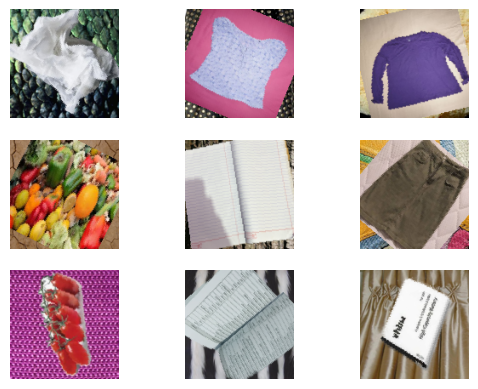

IndexError: index 6 is out of bounds for dimension 0 with size 6

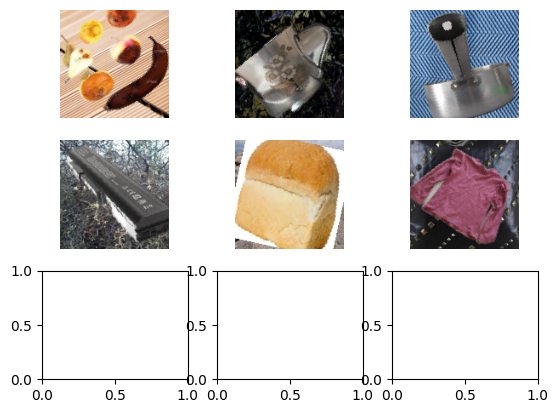

In [7]:
show_dataloader = DataLoader(dataset, batch_size=9, shuffle=True)
iterator = iter(show_dataloader)
for _ in range(3):
    fig, ax = plt.subplots(3, 3)
    batch = next(iterator)
    for i, ax_row in enumerate(ax):
        for j, a in enumerate(ax_row):
            a.imshow(batch[0][i * 3 + j].permute(1, 2, 0))
            a.axis('off')
    plt.show()

## Models

In [10]:
teacher = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
student = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V2)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /home/wizard/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 48.6MB/s]


In [20]:
teacher.fc = nn.Linear(512, len(CLASSES))
student.classifier[3] = nn.Linear(1280, len(CLASSES))

teacher = teacher.to(device)
student = student.to(device)

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_teacher(model:nn.Module, 
                  train_loader: DataLoader, 
                  val_loader: DataLoader, 
                  num_epochs=10, 
                  lr=1e-3, 
                  device=device):

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    for epoch in range(num_epochs):

        # --- training

        model.train()
        running_loss = 0.0
        total = 0
        
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for imgs, labels in loop:
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            
            loop.set_postfix(loss=loss.item())
        
        scheduler.step()
        train_loss = running_loss / total
        
        # --- validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"[Validation]", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * imgs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss /= val_total
        val_acc = val_correct / val_total
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}| "
                f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

def test(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy


In [34]:
train_teacher(teacher, 
              train_loader=train_loader,
              val_loader=val_loader)

Epoch 1: Train Loss=0.0000| Val Loss=0.0000, Val Acc=1.0000


Epoch 2: Train Loss=0.0000| Val Loss=0.0000, Val Acc=1.0000


Epoch 3: Train Loss=0.0000| Val Loss=0.0000, Val Acc=1.0000


Epoch 4: Train Loss=0.0000| Val Loss=0.0000, Val Acc=1.0000


Epoch 5: Train Loss=0.0000| Val Loss=0.0000, Val Acc=1.0000


Epoch 6: Train Loss=0.0000| Val Loss=0.0000, Val Acc=1.0000


Epoch 7: Train Loss=0.0000| Val Loss=0.0000, Val Acc=1.0000


Epoch 8: Train Loss=0.0000| Val Loss=0.0000, Val Acc=1.0000


Epoch 9: Train Loss=0.0000| Val Loss=0.0000, Val Acc=1.0000


Epoch 10: Train Loss=0.0000| Val Loss=0.0000, Val Acc=1.0000


In [35]:
def train_knowledge_distillation(teacher: nn.Module, 
                                 student: nn.Module, 
                                 train_loader: DataLoader, 
                                 val_loader: DataLoader,
                                 epochs: int, 
                                 learning_rate: float=1e-3, 
                                 temperature: float=2.0, 
                                 soft_target_loss_weight: float=0.25, 
                                 ce_loss_weight: float=0.75,
                                 device=device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(student.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    
    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        total = 0

        # --- training

        for inputs, labels in tqdm(train_loader, desc='[Train]', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            total += labels.shape[0]

            optimizer.zero_grad()

            with torch.no_grad():
                teacher_logits = teacher(inputs)

            student_logits = student(inputs)

            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / temperature, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / temperature, dim=-1)

            # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (temperature**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()
        train_loss = running_loss / total
        
        # --- validation
        student.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"[Validation]", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = student(imgs)
                loss = ce_loss(outputs, labels)
                
                val_loss += loss.item() * imgs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss /= val_total
        val_acc = val_correct / val_total
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f} | "
                f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

In [36]:
train_knowledge_distillation(
    teacher=teacher,
    student=student,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=10)

Epoch 1: Train Loss=0.3183 | Val Loss=0.0000, Val Acc=1.0000


Epoch 2: Train Loss=0.0005 | Val Loss=0.0000, Val Acc=1.0000


Epoch 3: Train Loss=0.0003 | Val Loss=0.0000, Val Acc=1.0000


Epoch 4: Train Loss=0.0003 | Val Loss=0.0000, Val Acc=1.0000


Epoch 5: Train Loss=0.0002 | Val Loss=0.0000, Val Acc=1.0000


Epoch 6: Train Loss=0.0001 | Val Loss=0.0000, Val Acc=1.0000


Epoch 7: Train Loss=0.0000 | Val Loss=0.0000, Val Acc=1.0000


Epoch 8: Train Loss=0.0000 | Val Loss=0.0000, Val Acc=1.0000


Epoch 9: Train Loss=0.0000 | Val Loss=0.0000, Val Acc=1.0000


Epoch 10: Train Loss=0.0000 | Val Loss=0.0000, Val Acc=1.0000
